# Transfer Learning
- Pretrained ResNet50
- Custom dataset
- Add fully connected layer 

## 1. Settings
### 1) Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision


### 2) Hyperparameters

In [2]:
batch_size = 6
learning_rate = 0.001
epoch = 50
num_category = 2

## 2. Data
### 1) Load images from folder

In [3]:
#데이터 위치
data_dir = "./data"

data_transforms = { 
                #더 좋은 학습을 위해 데이터 증강기법 도입!
                'train': transforms.Compose([
                        transforms.RandomResizedCrop(224), #사이즈변환 224x224
                        transforms.RandomHorizontalFlip(), #임의의 횡축 접기
                        transforms.ToTensor(), #텐서로 바꾸기
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #정규화
                ]),
                'val': transforms.Compose([
                        transforms.Resize(256),#사이즈변환 256x256
                        transforms.CenterCrop(224), #중앙 잘라내기
                        transforms.ToTensor(), #텐서로 바꾸기
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
}

train_set = datasets.ImageFolder(data_dir, transform = data_transforms)
val_set = datasets.ImageFolder(data_dir, transform = data_transforms)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir),
                                                data_transforms[x])
                                                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("레이블 개수: ", dataset_sizes)
print("클래스 이름: ", class_names)
class_num = len(class_names)
print("클래스 개수: ", class_num)
print(device)

레이블 개수:  {'train': 6, 'val': 6}
클래스 이름:  ['dogs', 'onepun']
클래스 개수:  2
cuda:0


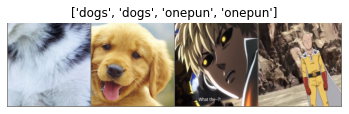

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 3. Model & Optimizer
### 1) ResNet

In [5]:
# children() -> immediate children modules 
# modules() -> iterate all modules

model = models.resnet50(pretrained=True)

for name,module in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


### 2) Finetuning the convnet

In [6]:
# 가장 마지막 부분을 기존의 1000->2로 바꿔줍니다.
model = models.resnet50(pretrained=True)
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, class_num)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# 통계적 경사하강법실시합니다.
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Adam도 좋은 학습 Optimizer입니다.
# optimizer_ft= optim.Adam(model.parameters(), lr=0.001)

# 학습률 감소를 매 7에폭마다 0.1씩 감소시켜줍니다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
#수업시간에 배운 위에는 전이학습을(Transfer Learning)을 이용하여 
#어느정도 학습 weight를 갱신시키고 싶지 않다면? 다음과 같은 주석을 해제시켜주면 됩니다.
# for param in model.parameters():
#     param.requires_grad = False

### 3) Model on GPU

In [8]:
model.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
for name in model.children():
    print(name)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

### 4) Loss & Optimizer

In [10]:
# define loss func & optimizer
# model.parameters() also works because of the cell right above

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate) 

In [11]:
#학습 진행률 코드관련
import re
from tqdm import trange

class DescStr:
	def __init__(self):
	  self._desc = ''
	
	def write(self, instr):
	  self._desc += re.sub('\n|\x1b.*|\r', '', instr)
	
	def read(self):
	  ret = self._desc
	  self._desc = ''
	  return ret
	
	def flush(self):
	  pass

## 4. Train

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    tbar = trange(num_epochs)
    desc = DescStr()
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tbar:
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 각 Epoch당 돌아줍니다.
            for inputs, labels in dataloaders[phase]:
                tbar.set_description(desc.read()) #진행률관련
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 기울기 감소법
                optimizer.zero_grad()

                # 포워드
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #가장 높은 확률의 예측값 골라내기
                    loss = criterion(outputs, labels)
                    
                    # 역전파, 최적화 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # 정확도 관련
                running_loss += loss.item() * inputs.size(0)
                #맞는것들이 있는것들만 추려내기
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            #에폭 손실 체크
            epoch_loss = running_loss / dataset_sizes[phase]
            #정확도체크
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  
            tbar.set_postfix(epoch = f'{epoch/num_epochs}', \
                            # 표시하고 싶은 변수 입력
                            loss = epoch_loss, accuracy = epoch_acc.item()* 100.) 
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 최고의 모델을 반환시켜줍니다.
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epoch)

100%|██████████| 50/50 [01:59<00:00,  2.38s/it, accuracy=100, epoch=49, loss=0.0817]

Training complete in 1m 59s
Best val Acc: 1.000000


In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

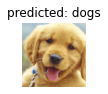

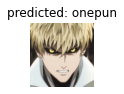

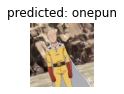

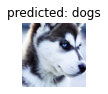

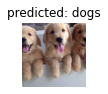

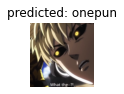

In [15]:
visualize_model(model)
plt.ioff()
plt.show()

## 6. Test

In [16]:
data_dir = './data'
#테스트 데이터는 데이터 증강을 하지 않습니다.
test_transform = transforms.Compose([
                        transforms.Resize((224, 224)), #사이즈변환 255x255 
                        transforms.ToTensor(), #텐서로 바꾸기
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #정규화
                ])

test_set = datasets.ImageFolder(data_dir, transform = test_transform)
test_batch = DataLoader(test_set, batch_size=batch_size,
                            shuffle=True, num_workers=2)

In [17]:
#최종 테스트
model.eval()
correct = 0
total = 0

for img,label in test_batch:
    img = Variable(img).cuda()
    label = Variable(label).cuda()
    
    output = model(img)
    _, pred = torch.max(output.data,1)
    
    total += label.size(0)
    correct += (pred == label.data).sum()   

print("Accuracy: {}".format(correct/total))

Accuracy: 1.0


# 7. Model Save
### 모델을 저장해 봅시다.

In [18]:
#모델 저장하기
torch.save(model.state_dict(), './model.pth')


# 8. Model Load
### 모델을 불러와 봅시다.

In [19]:
#빈 모델 불러오기
model = models.resnet50(pretrained=False)
# 가장 마지막 부분을 기존의 1000->2로 바꿔줍니다.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, class_num)
model = model.to(device)
#모델안의 값을 출력
for idx, i in enumerate(model.parameters()):
    print(i)


Parameter containing:
tensor([[[[ 3.5152e-02,  5.9229e-05,  2.7020e-02,  ...,  2.9414e-02,
           -4.4857e-02,  1.7925e-02],
          [ 3.3000e-02,  3.1192e-02,  2.1076e-02,  ...,  1.1848e-02,
            3.4557e-02, -5.4210e-02],
          [ 2.1802e-02, -1.5265e-02, -5.6197e-03,  ..., -3.1834e-02,
            7.4533e-03,  3.4085e-02],
          ...,
          [-1.3782e-02,  3.8212e-03, -9.5057e-03,  ..., -2.2371e-02,
           -4.2443e-02,  2.1019e-02],
          [-2.5657e-03,  7.1498e-02,  2.0424e-03,  ...,  1.2364e-02,
            8.8402e-03, -1.2991e-02],
          [-1.4560e-02,  1.8587e-02, -1.1601e-02,  ..., -4.4768e-02,
            3.7567e-04,  2.0511e-02]],

         [[-1.1848e-02,  4.0767e-02,  1.6445e-02,  ..., -4.4795e-02,
           -2.5784e-02,  6.5465e-02],
          [-2.0961e-02, -5.0787e-02,  4.2664e-02,  ...,  3.1680e-03,
           -1.6216e-02,  5.7408e-03],
          [ 7.7289e-03,  2.1243e-02, -3.1305e-02,  ...,  1.1615e-02,
            3.6720e-02,  8.8213e-03]

In [20]:
#그동안 학습한 값을 확인
model.load_state_dict(torch.load('./model.pth', map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
for idx, i in enumerate(model.parameters()):
    print(i)


Parameter containing:
tensor([[[[ 1.3244e-02,  1.4582e-02, -1.5427e-02,  ..., -4.0969e-02,
           -4.3100e-02, -7.0810e-02],
          [ 4.0478e-03,  5.7849e-03,  1.4900e-02,  ...,  2.1633e-03,
           -2.0950e-02, -3.8544e-02],
          [ 2.2275e-02,  2.3551e-02,  1.6088e-02,  ...,  1.0277e-01,
            6.2607e-02,  5.1942e-02],
          ...,
          [-9.4510e-04,  2.7735e-02, -1.0133e-02,  ..., -1.2727e-01,
           -7.6635e-02,  7.8182e-03],
          [ 3.5516e-03,  4.7968e-02,  6.2016e-02,  ...,  2.4219e-02,
           -3.3688e-02, -1.5730e-02],
          [-8.0063e-02, -3.2274e-02, -1.7843e-02,  ...,  3.5315e-02,
            2.2413e-02,  1.6836e-03]],

         [[-1.8576e-02,  1.1300e-02,  2.3739e-02,  ...,  5.3622e-02,
            4.3914e-02, -9.5617e-03],
          [-7.8355e-03,  1.8792e-02,  6.7895e-02,  ...,  1.5947e-01,
            1.4598e-01,  1.1992e-01],
          [-4.6107e-02, -7.6155e-02, -8.9718e-02,  ...,  1.2099e-01,
            1.6697e-01,  1.7611e-01]

In [21]:
        
device = torch.device("cuda")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # 확률과 클래스를 반환
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [30]:
# 이미지 경로를 받아오면 딥러닝 형태로 변환해주는 함수
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # 사이즈
    width, height = img.size
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255)) # 255 x 255 사이즈로 변환
    
    # 변화된 사이즈
    width, height = img.size
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    img = np.array(img)
    print(img.shape)
    # Chnnel이 먼저되게끔 설정(tensor로 변환)
    img = img.transpose((2, 0, 1))
    
    # 0~1로 변환
    img = img/255
    
    # Normalize 실시
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # 배치사이즈삽입 1
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [31]:
# Process Image
image = process_image("data/dogs/retriever.jpg")
# Give image to model to predict output

top_prob, top_class = predict(image.cuda(), model)
print(top_prob, top_class)
# Show the image

# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class)

(224, 224, 3)
0.7661653161048889 1
The model is  76.61653161048889 % certain that the image has a predicted class of  1


(-0.5, 735.5, 719.5, -0.5)

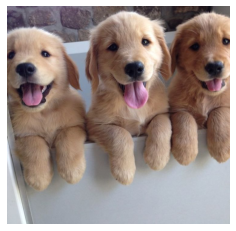

In [34]:
plt.imshow(Image.open("data/dogs/retriever.jpg"))
plt.axis('off')